<a href="https://colab.research.google.com/github/jameselroy/emotion_detection/blob/main/Face_Emotion_Recognition_james.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Emotion Recognition**










# **Introduction**
The Indian education landscape has been undergoing rapid changes for the past 10 years owing to
the advancement of web-based learning services, specifically, eLearning platforms.

Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India
is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market
is growing on a rapid scale, there are major challenges associated with digital learning when
compared with brick and mortar classrooms. One of many challenges is how to ensure quality
learning for students. Digital platforms might overpower physical classrooms in terms of content
quality but when it comes to understanding whether students are able to grasp the content in a live
class scenario is yet an open-end challenge.

In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the
class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who
need special attention. Digital classrooms are conducted via video telephony software program (exZoom) where it’s not possible for medium scale class (25-50) to see all students and access the
mood. Because of this drawback, students are not focusing on content due to lack of surveillance.
While digital platforms have limitations in terms of physical surveillance but it comes with the power of
data and machines which can work for you. It provides data in the form of video, audio, and texts
which can be analysed using deep learning algorithms. Deep learning backed system not only solves
the surveillance issue, but it also removes the human bias from the system, and all information is no
longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

# **Objective**
Our objective is to solve the above mentioned challenge by applying deep learning algorithms to live video data inorder to recognize the facial emotions and categorize them accordingly.

# **Dataset used**
We have utilized the [FER 2013](https://www.kaggle.com/datasets/msambare/fer2013) dataset provided on Kaggle.<br>
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.<br>

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

### **Let's Begin:**

# **Data Exploration:**

**Lets start by importing the required libraries.**

In [ ]:
# Basic python libraries.
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get rid of warnings!
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries.
import tensorflow as tf
from keras_preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.layers import Dense,Dropout,GlobalAveragePooling2D,MaxPooling2D,Flatten,Conv2D,BatchNormalization,Activation
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.utils import plot_model
#from keras.preprocessing import image
from keras_preprocessing import image
from sklearn.metrics import confusion_matrix
import itertools

print('Above libraries have been imported.')

Above libraries have been imported.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/alma_capstone_project/capstone5_face_emotion/FER 2013 Dataset.zip'

In [ ]:
from zipfile import ZipFile
with ZipFile(file_path , 'r') as ZipFile:
  ZipFile.extractall()
  print('Zip file extracted successfully')

Zip file extracted successfully


**Seperate the Training and Validation Data.**

In [ ]:
# Define the train and validataion data paths.
train_dir = '/content/train'
val_dir = '/content/test'

**Have a look at our data.**

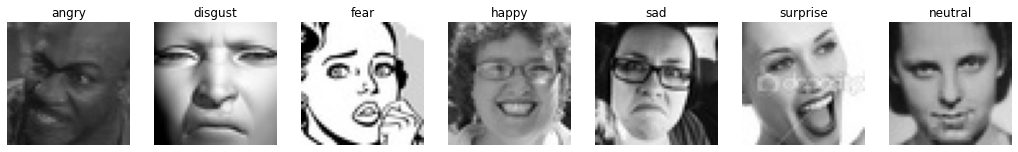

In [ ]:
# Define the default image size.
img_size = 48

# Define the seven emotions provided in dataset.
emotion_list = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Plot the images with each distinct emotions.
plt.figure(figsize=(18,22))
i = 1
for expression in emotion_list:
    img = load_img((train_dir + '/' + expression +'/'+ os.listdir(train_dir + '/' + expression)[59]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

**Perform some Data Augmentation on train and validations sets.**

# **Data Preprocessing:**

In [ ]:
# Rescale the data.
'''
Before we proceed we need to rescale our data by multiplying it to 1/255.
This is done so we get target values between 0 and 1.
'''
# Rescale train data.
datagen_train = ImageDataGenerator(rescale = 1./255,
                                  )

# Rescale validation data.
datagen_val = ImageDataGenerator(rescale = 1./255,
                                 )

print('Above data generator functions have been created.')

Above data generator functions have been created.


In [ ]:
# Perform data augmentation.
'''
Data augmentation is a technique to artificially create new training data from existing training data. 
It helps us to increase the size of the dataset and introduce variability in the dataset.
'''
# Define the default image size.
img_size = 48

# Define batch size.
batch_size = 64

# Training data.
train_set = datagen_train.flow_from_directory(directory=train_dir,
                                              target_size=(img_size,img_size),
                                              batch_size = batch_size,
                                              color_mode = 'grayscale',
                                              class_mode = "categorical",
                                              shuffle=True
                                              )

# Validation data.
val_set = datagen_train.flow_from_directory(directory=val_dir,
                                              target_size=(img_size,img_size),
                                              batch_size = batch_size,
                                              color_mode = 'grayscale',
                                              class_mode = "categorical",
                                              shuffle=False
                                              )

print('Train and Validation sets have been created.')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Train and Validation sets have been created.


**Now lets create our custom CNN model.**

# **Build CNN Model:**

**Before we start building the neural network lets understand some of the terms that we will be using.**

* **Model = sequential** : A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

* **Padding** = The padding parameter of the Keras Conv2D class can take one of two values: 'valid' or 'same'. Setting the value to “valid” parameter means that the input volume is not zero-padded and the spatial dimensions are allowed to reduce via the natural application of convolution.

* **Activation** = relu :The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.

* **Maxpooling** = Maximum pooling, or max pooling, is a pooling operation that calculates the maximum, or largest, value in each patch of each feature map. The results are down sampled or pooled feature maps that highlight the most present feature in the patch, not the average presence of the feature in the case of average pooling.

* **Batch normalization** = Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

* **Dropout** = Dropout is a technique used to prevent a model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase.

* **Adam** = Adaptive Moment Estimation is an algorithm for optimization technique for gradient descent. The method is really efficient when working with large problem involving a lot of data or parameters. It requires less memory and is efficient. Intuitively, it is a combination of the ‘gradient descent with momentum’ algorithm and the ‘RMSP’ algorithm. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.

In [ ]:
# First layer
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second layer
model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third layer   
model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fourth layer
model.add(Conv2D(256,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# First fully connected layer
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))

# Second fully connected layer  
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

print('CNN model has been created you can proceed to train you data with this model.')

CNN model has been created you can proceed to train you data with this model.


In [ ]:
# Get model summary.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

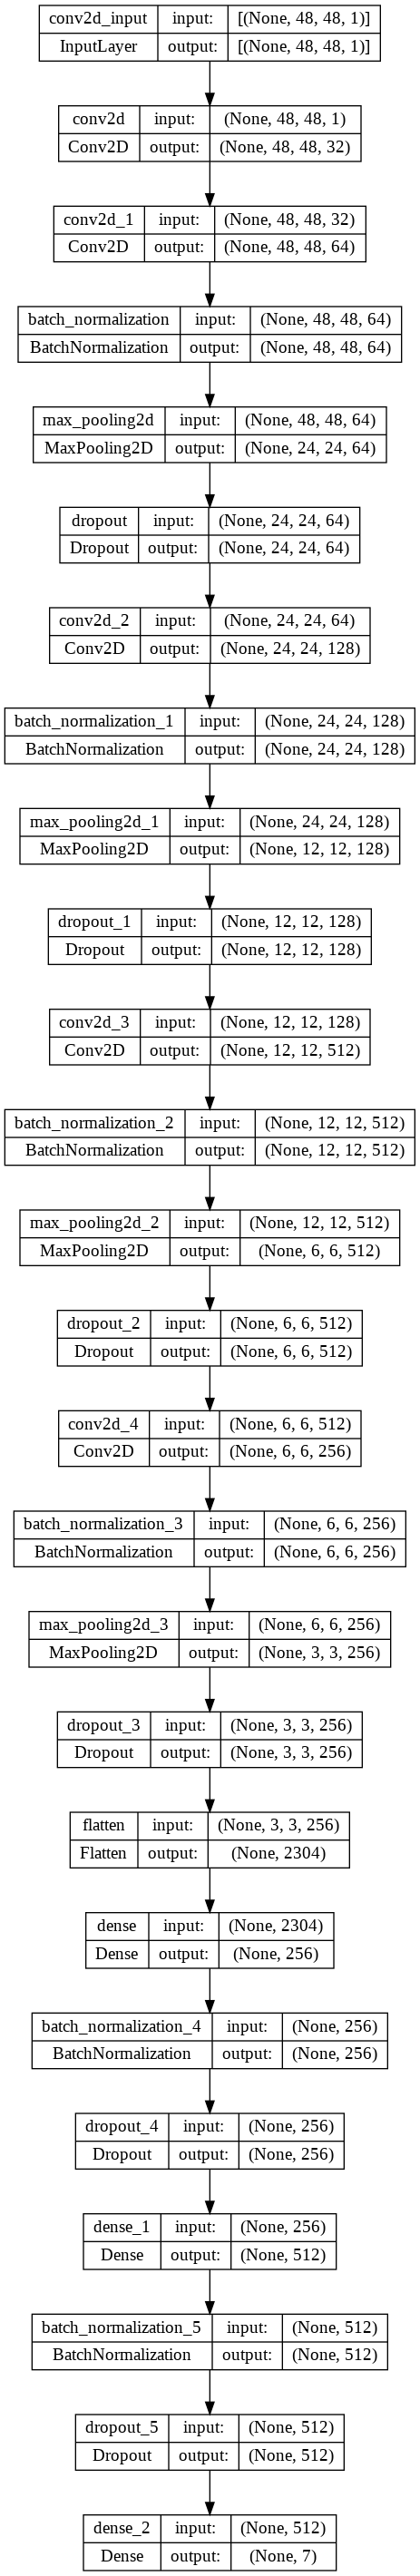

In [ ]:
# Visualize the model.
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Now lets fit the data to our model.
history = model.fit_generator(generator = train_set,
                              steps_per_epoch=train_set.n//train_set.batch_size,
                              validation_data = val_set,
                              validation_steps=val_set.n//val_set.batch_size,
                              epochs = 15)

print('Your model has been trained!!')

Epoch 1/15
448/448 [==============================] - 27s 38ms/step - loss: 1.9976 - accuracy: 0.2741 - val_loss: 2.3365 - val_accuracy: 0.2617
Epoch 2/15
448/448 [==============================] - 16s 36ms/step - loss: 1.4964 - accuracy: 0.4318 - val_loss: 1.4245 - val_accuracy: 0.4640
Epoch 3/15
448/448 [==============================] - 16s 36ms/step - loss: 1.2889 - accuracy: 0.5108 - val_loss: 1.2337 - val_accuracy: 0.5276
Epoch 4/15
448/448 [==============================] - 16s 37ms/step - loss: 1.1843 - accuracy: 0.5512 - val_loss: 1.1890 - val_accuracy: 0.5594
Epoch 5/15
448/448 [==============================] - 16s 36ms/step - loss: 1.1143 - accuracy: 0.5784 - val_loss: 1.1429 - val_accuracy: 0.5770
Epoch 6/15
448/448 [==============================] - 16s 36ms/step - loss: 1.0533 - accuracy: 0.5999 - val_loss: 1.1336 - val_accuracy: 0.5771
Epoch 7/15
448/448 [==============================] - 16s 37ms/step - loss: 0.9986 - accuracy: 0.6261 - val_loss: 1.2164 - val_accuracy:

# **Model evaluation:**

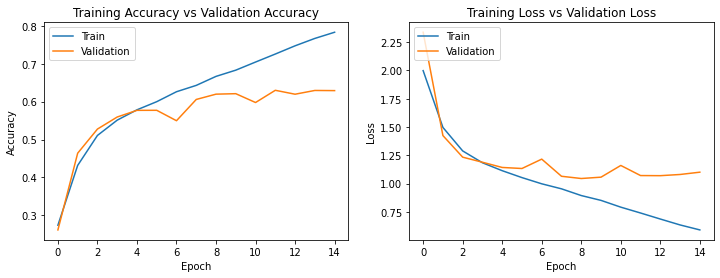

In [ ]:
# Create plots for accuracy and loss.
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

<Figure size 432x288 with 0 Axes>

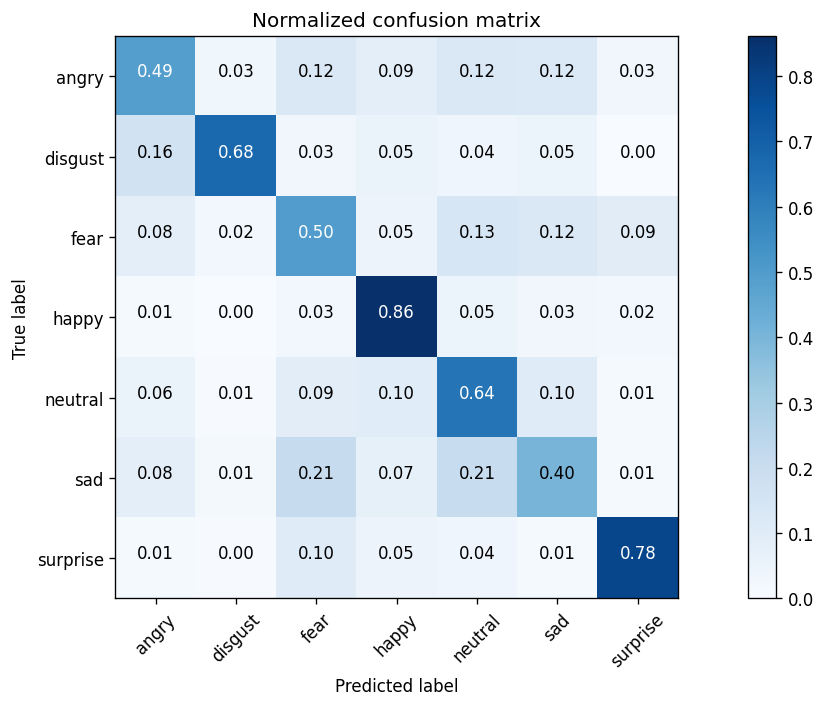

In [ ]:
# Create confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=val_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = val_set.classes
class_names = val_set.class_indices.keys()

# Create function to plot confussion matrix.
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,6), dpi=120)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')# **Live Class Monitoring System(Face Emotion Recognition)**
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

# **Test the model:**

(48, 48)


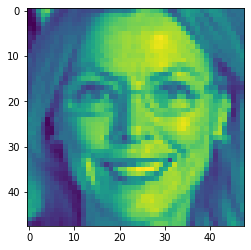

In [ ]:

img = image.load_img("/content/train/happy/Training_1018317.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape) 

In [ ]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [ ]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

1/1 [==============================] - 0s 291ms/step
[6.89748e-15, 0.0, 2.328905e-37, 1.0, 0.0, 0.0, 0.0]


In [ ]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Happy


In [ ]:
model.save('model_78.h5')

In [ ]:
model.save_weights('model_weights_78.h5')

# **Conclusions:**

* **Using the dataset from kaggle we were able to build a CNN model which is capable of recognizing the facial emotion of a user.**

* **The model obtained 77% accuracy on training set and 64% accuracy on validation set.**

* **From the confussion matrix we saw that our model does a good job in predicting most of the classes but the performance is comparatively lower in classes angry and fear. This might be caused due to fewer amount of data present for these classes.**
* **Finally we tested the model using a image and it was able to predict it correctly which proves that our model works perfectly.**